<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import sys
sys.path.append('../')
import datetime as dt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from math import trunc
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
import os
import pandas as pd
import pickle
from tqdm.auto import tqdm
from src.pipeline_helpers import get_proportions
from src.clean_data import normalize_text
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow_addons as tfa
from keras.layers import Input, Dense, Embedding, Flatten, Activation,Bidirectional, LSTM, Dropout, SpatialDropout1D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

In [2]:
PROJECT_PATH = os.path.dirname(os.getcwd())
DATA_PATH = PROJECT_PATH + '/data/'
MODEL_PATH = PROJECT_PATH + '/models/'
LEMMATIZED_PATH = DATA_PATH + 'lemmatized/'
STEMMED_PATH = DATA_PATH + 'stemmed/'
MODEL_PATH = os.path.dirname(PROJECT_PATH) + '/models/'

In [3]:
X = np.load(LEMMATIZED_PATH + 'X_lemmatized_prepared.npy')
y = np.load(LEMMATIZED_PATH + 'y_lemmatized_prepared.npy')

In [4]:
#loading the lemmatized class weghts, we will pass these to Keras class weight param
with open(LEMMATIZED_PATH + 'lemmatized_class_weights.pickle', 'rb') as f:
    lemmatized_class_weights = pickle.load(f)

In [5]:
#loading class names
with open(LEMMATIZED_PATH + 'class_names.pickle', 'rb') as f:
    class_names = pickle.load(f)

In [6]:
print(lemmatized_class_weights)

{0: 0.522652455917343, 1: 29.47702205882353, 2: 5.891072740631889, 3: 0.39201329894512965, 4: 3.011361502347418}


In [7]:
#view the number in each class
print(y.sum(axis=0))

[61362  1088  5444 81811 10650]


In [8]:
X.shape

(160355, 200)

In [9]:
y.shape

(160355, 5)

In [10]:
y

array([[0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0]])

In [11]:
print(X)

[[ 86 151   9 ...   0   0   0]
 [ 11   5   6 ...   0   0   0]
 [ 11   5   6 ...   0   0   0]
 ...
 [ 39  55  76 ...   0   0   0]
 [ 86 173  22 ...   0   0   0]
 [ 39 436  46 ...   0   0   0]]


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state = 42, stratify = y_test)

Now we will check the proportions of each class in the training set and test set to ensure that Sklearn's stratify worked as expected. I defined a function in pipeline_helpers to calculate the proportion of each class. 

In [15]:
y_train_proportions = get_proportions(y_train)
y_test_proportions = get_proportions(y_test)
y_val_proportions = get_proportions(y_val)

print(f"y_train proportions: \n {y_train_proportions}\n")
print(f"y_test proportions: \n {y_test_proportions}\n")
print(f"y_val proportions: \n {y_val_proportions}")

y_train proportions: 
 {0: 0.38266658351781985, 1: 0.006789623023915687, 2: 0.03395591032396869, 3: 0.5101961273424589, 4: 0.0664229366093979}

y_test proportions: 
 {0: 0.38272528843155595, 1: 0.006859993763642033, 2: 0.0339881509198628, 3: 0.5101964452759589, 4: 0.06647957592765824}

y_val proportions: 
 {0: 0.38270142180094785, 1: 0.006859565976552756, 2: 0.034048391119980044, 3: 0.5101646295834372, 4: 0.0664754302818658}


In [16]:
#view the number in each class
print(y_train.sum(axis=0))

[49090   870  4355 65449  8520]


In [17]:
X_train.shape

(128284, 200)

In [18]:
y_train.shape

(128284, 5)

In [19]:
y_val.shape

(16036, 5)

In [20]:
#define model parameters, we will use a large number of epochs as we'll 
# implement early stopping when our model overfits
num_words = 10000
num_epochs = 300
embed_dims = 32

#define metrics to monitor
metrics = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.AUC(name='auc'),
]

In [21]:
#define callbacks for our model
checkpoint = ModelCheckpoint(filepath=MODEL_PATH+f'LSTM/model_{dt.datetime.now().strftime("%Y-%m-%d--%H:%M:%S")}_best.h5', 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

tqdm_callback = tfa.callbacks.TQDMProgressBar()

callbacks = [checkpoint,
             early_stopping,
             tqdm_callback]

In [22]:
#build our model
model = Sequential()
model.add(Embedding(num_words, embed_dims, 
                    input_length=X_train.shape[1], mask_zero=True))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           320000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 5)                 505       
Total params: 373,705
Trainable params: 373,705
Non-trainable params: 0
_________________________________________________________________


In [23]:
#we will use the Ada optimizer with the default learning rate
opt = tf.keras.optimizers.Adam()
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=metrics
)

In [24]:
#fit model
history = model.fit(X_train, y_train, epochs=num_epochs, 
                    validation_data=(X_val, y_val), verbose=2,
                    class_weight=lemmatized_class_weights,
                    callbacks=callbacks)


Training:   0%|                                                      0/300 ETA: ?s,  ?epochs/s

2021-11-04 15:14:30.336772: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300
Epoch 1/300


0/4009                                                                              ETA: ?s - 

4009/4009 - 840s - loss: 0.7045 - accuracy: 0.7294 - auc: 0.9177 - val_loss: 0.6251 - val_accuracy: 0.7855 - val_auc: 0.9482

Epoch 00001: val_loss improved from inf to 0.62512, saving model to /Users/WillemCole/Desktop/DataScience/sf_building_complaints/models/LSTM/model_2021-11-04--15:14:12_best.h5
Epoch 2/300
Epoch 2/300


0/4009                                                                              ETA: ?s - 

4009/4009 - 845s - loss: 0.4752 - accuracy: 0.7831 - auc: 0.9512 - val_loss: 0.5857 - val_accuracy: 0.7904 - val_auc: 0.9554

Epoch 00002: val_loss improved from 0.62512 to 0.58575, saving model to /Users/WillemCole/Desktop/DataScience/sf_building_complaints/models/LSTM/model_2021-11-04--15:14:12_best.h5
Epoch 3/300
Epoch 3/300


0/4009                                                                              ETA: ?s - 

4009/4009 - 834s - loss: 0.4397 - accuracy: 0.7951 - auc: 0.9580 - val_loss: 0.5869 - val_accuracy: 0.7886 - val_auc: 0.9547

Epoch 00003: val_loss did not improve from 0.58575
Epoch 4/300
Epoch 4/300


0/4009                                                                              ETA: ?s - 

4009/4009 - 829s - loss: 0.4111 - accuracy: 0.8016 - auc: 0.9618 - val_loss: 0.5351 - val_accuracy: 0.8114 - val_auc: 0.9621

Epoch 00004: val_loss improved from 0.58575 to 0.53509, saving model to /Users/WillemCole/Desktop/DataScience/sf_building_complaints/models/LSTM/model_2021-11-04--15:14:12_best.h5
Epoch 5/300
Epoch 5/300


0/4009                                                                              ETA: ?s - 

4009/4009 - 820s - loss: 0.3901 - accuracy: 0.8094 - auc: 0.9644 - val_loss: 0.5750 - val_accuracy: 0.7904 - val_auc: 0.9569

Epoch 00005: val_loss did not improve from 0.53509
Epoch 6/300
Epoch 6/300


0/4009                                                                              ETA: ?s - 

4009/4009 - 824s - loss: 0.3808 - accuracy: 0.8132 - auc: 0.9660 - val_loss: 0.5176 - val_accuracy: 0.8082 - val_auc: 0.9648

Epoch 00006: val_loss improved from 0.53509 to 0.51764, saving model to /Users/WillemCole/Desktop/DataScience/sf_building_complaints/models/LSTM/model_2021-11-04--15:14:12_best.h5
Epoch 7/300
Epoch 7/300


0/4009                                                                              ETA: ?s - 

4009/4009 - 848s - loss: 0.3655 - accuracy: 0.8190 - auc: 0.9681 - val_loss: 0.5196 - val_accuracy: 0.8120 - val_auc: 0.9654

Epoch 00007: val_loss did not improve from 0.51764
Epoch 8/300
Epoch 8/300


0/4009                                                                              ETA: ?s - 

4009/4009 - 937s - loss: 0.3535 - accuracy: 0.8209 - auc: 0.9688 - val_loss: 0.5243 - val_accuracy: 0.8085 - val_auc: 0.9642

Epoch 00008: val_loss did not improve from 0.51764
Epoch 9/300
Epoch 9/300


0/4009                                                                              ETA: ?s - 

4009/4009 - 957s - loss: 0.3447 - accuracy: 0.8245 - auc: 0.9701 - val_loss: 0.5131 - val_accuracy: 0.8106 - val_auc: 0.9659

Epoch 00009: val_loss improved from 0.51764 to 0.51310, saving model to /Users/WillemCole/Desktop/DataScience/sf_building_complaints/models/LSTM/model_2021-11-04--15:14:12_best.h5
Epoch 10/300
Epoch 10/300


0/4009                                                                              ETA: ?s - 

4009/4009 - 971s - loss: 0.3396 - accuracy: 0.8275 - auc: 0.9710 - val_loss: 0.5292 - val_accuracy: 0.8071 - val_auc: 0.9641

Epoch 00010: val_loss did not improve from 0.51310
Epoch 11/300
Epoch 11/300


0/4009                                                                              ETA: ?s - 

4009/4009 - 965s - loss: 0.3298 - accuracy: 0.8298 - auc: 0.9722 - val_loss: 0.5594 - val_accuracy: 0.7938 - val_auc: 0.9603

Epoch 00011: val_loss did not improve from 0.51310
Epoch 12/300
Epoch 12/300


0/4009                                                                              ETA: ?s - 

4009/4009 - 1062s - loss: 0.3196 - accuracy: 0.8319 - auc: 0.9727 - val_loss: 0.5308 - val_accuracy: 0.8083 - val_auc: 0.9636

Epoch 00012: val_loss did not improve from 0.51310
Epoch 13/300
Epoch 13/300


0/4009                                                                              ETA: ?s - 

4009/4009 - 1035s - loss: 0.3133 - accuracy: 0.8355 - auc: 0.9735 - val_loss: 0.5496 - val_accuracy: 0.8033 - val_auc: 0.9616

Epoch 00013: val_loss did not improve from 0.51310
Epoch 14/300
Epoch 14/300


0/4009                                                                              ETA: ?s - 

4009/4009 - 817s - loss: 0.3092 - accuracy: 0.8359 - auc: 0.9740 - val_loss: 0.5461 - val_accuracy: 0.8014 - val_auc: 0.9623

Epoch 00014: val_loss did not improve from 0.51310


In [25]:
#save model history
with open(MODEL_PATH + f'/LSTM/model_history.pickle', 'wb') as f:
        pickle.dump(history.history, f)

In [47]:
# Evaluate the model on the test data
y_pred = model.predict(X_test)

In [48]:
weighted_auc = metrics.roc_auc_score(y_test, y_pred, 
                            average='weighted',multi_class='ovr')
print(f'Weighted AUC: {weighted_auc}')
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1) 

accuracy = metrics.accuracy_score(y_true, y_pred, normalize=True)
print(f'Accuracy: {accuracy}')

print(f'Class Names: {class_names}')

#create confusion matrix of our test predictions
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
print(f'Confusion Matrix: \n {confusion_matrix}')
classification_report = metrics.classification_report(y_true, y_pred)
#create classification report
print(f'Classification Report: \n {classification_report}')

Weighted AUC: 0.941873462453858
Accuracy: 0.7996881821016526
Class Names: ['Building Inspection Division' 'Disabled Access Division'
 'Electrical Inspection Division' 'Housing Inspection Services'
 'Plumbing Inspection Division']
Confusion Matrix: 
 [[4983   96  242  505  310]
 [   7   90    2    9    1]
 [  43    3  451   25   22]
 [ 769  110  351 6404  547]
 [  71    8   40   51  895]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      6136
           1       0.29      0.83      0.43       109
           2       0.42      0.83      0.55       544
           3       0.92      0.78      0.84      8181
           4       0.50      0.84      0.63      1065

    accuracy                           0.80     16035
   macro avg       0.60      0.82      0.66     16035
weighted avg       0.84      0.80      0.81     16035



We can see that our model is having a lot of trouble recognizing the under-represented classes still, with especially low precision in the Disabled Access Division, this is a common problem for underbalanced classes and represents too many false positives for the class. The model is frequently mistaking it for the first class, and most likely their isn't enough data in the under-represented class for the model to learn the difference.

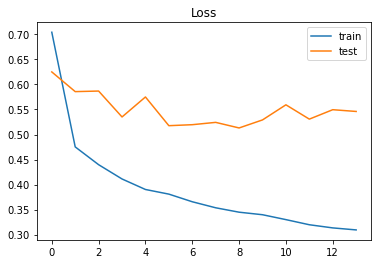

In [49]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

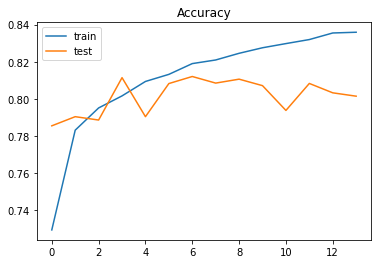

In [50]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

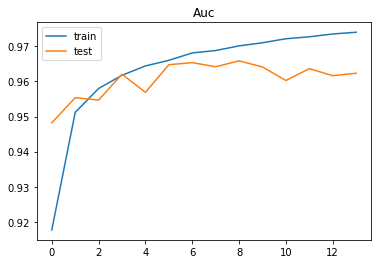

In [51]:
plt.title('Auc')
plt.plot(history.history['auc'], label='train')
plt.plot(history.history['val_auc'], label='test')
plt.legend()
plt.show();

The curves here seem to also show that our model is having trouble learning the data, and is having trouble distinguishing between classes. I explored using more sophisticated architectures but the model didn't perform any better on the validation data, ending up at the same AUC. 

Next we will explore using transfer learning using a pretrained BERT model on the data with the hope that the BERT model will be able to distinguish between classes better. 